In [6]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
 
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from keras.utils import to_categorical, normalize

import psycopg2
from configparser import ConfigParser
plt.style.use('fivethirtyeight')

pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

print ('import completed')

import completed


In [2]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
#timesteps per samples
Enrol_window = 20

print ('enrol window set to',Enrol_window )

enrol window set to 20


In [29]:
# Support functions
scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()


# for multivariate, nth timesteps output is used for n timesteps input so first output before nth is not used (Multiple Input Series)
def split_multi(sequences, n_steps):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix, -1])
        
    return np.array(X), np.array(y)

def split_multi_output(sequences, n_steps_in, n_steps_out):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix:out_end_ix, -1])
        
    return np.array(X), np.array(y)
                           
#for univariate(1 feature)
def split_uni(sequences, n_steps,normalise_window):
    sequence_length = n_steps + 1
    result = []
    for index in range(len(sequences) - sequence_length):
        result.append(sequences[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    return np.array(result)
                           
def load_data(datasetname, column, seq_len, normalise_window, n_outputs):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]
    
    row = round(0.6 * data.shape[0])
    
    if normalise_window:
#         data = std_scaler.fit_transform(data)
        data = scaler.fit_transform(data)

#         data_x = data.iloc[:,:-1]
#         min_value, max_value = data_x.min().min(), data_x.max().max()
#         data_x = (data_x - min_value) / (max_value - min_value)
#         data.iloc[:,:-1] = data_x
        
#         data_y = data.iloc[:,-1]
#         min_value, max_value = data_y.min(), data_y.max()
#         data_y = (data_y - min_value) / (max_value - min_value)
#         data.iloc[:,-1] = data_y
        
    
    data = pd.DataFrame(data,columns = column)
    
    data_train = data[:int(row)]
    data_test = data[int(row):]
    
#     if normalise_window:
#         data_train = std_scaler.fit_transform(data_train)
#         data_test = std_scaler.transform(data_test)
        
#         data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
#           data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
# scaler_y = MinMaxScaler(feature_range=(0,1))
        
    
#     data = pd.DataFrame(data,columns = column)
#     data_test = pd.DataFrame(data_test,columns = data.columns)
    
    print(data.describe())
    feature, label = split_multi_output(data, seq_len, n_outputs)
    x_train, y_train = split_multi_output(data_train, seq_len, n_outputs)
    x_test, y_test = split_multi_output(data_test, seq_len, n_outputs)
    
#     y_train =to_categorical(y_train)
#     y_test =to_categorical(y_test)
#     print(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return [x_train, y_train, x_test, y_test, feature, label]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize = (12,12)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(predicted_data, label='Prediction', color ='red') 
    plt.legend() 
    plt.show() 

def plot_result(predicted_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [8]:
lq45 = ['ACES','ADRO','AKRA','ANTM','ASII',
            'BBCA','BBNI','BBRI','BBTN','BMRI',
            'BSDE','BTPS','CPIN','CTRA','ERAA',
            'EXCL','GGRM','HMSP','ICBP','INCO',
            'INDF','INKP','INTP','ITMG','JPFA',
            'JSMR','KLBF','MDKA','MIKA','MNCN',
            'PGAS','PTBA','PTPP','PWON','SCMA',
            'SMGR','SMRA','SRIL','TBIG','TKIM',
            'TLKM','TOWR','UNTR','UNVR','WIKA'
       ]

kompas100 = 'AALI,ACES,ADHI,ADRO,AKRA,ANTM,APLN,ASII,ASSA,BBCA,BBKP,BBNI,BBRI,BBTN,BDMN,BEST,BJBR,BJTM,BMRI,BMTR,BNLI,BRIS,BRPT,BSDE,BTPS,BULL,CLEO,CPIN,CTRA,DMAS,ELSA,ERAA,EXCL,GGRM,GIAA,HKMU,HMSP,HOKI,ICBP,INAF,INCO,INDF,INDY,INKP,INTP,ISAT,ITMG,JPFA,JRPT,JSMR,KAEF,KBLI,KINO,KLBF,LINK,LPKR,LPPF,LSIP,MAIN,MAPI,MDKA,MEDC,MIKA,MNCN,MTDL,MYOR,PGAS,PNBN,PNLF,PSAB,PTBA,PTPP,PWON,RALS,SCMA,SIDO,SILO,SIMP,SMBR,SMGR,SMRA,SMSM,SPTO,SRIL,SSIA,SSMS,TBIG,TINS,TKIM,TLKM,TOWR,TPIA,UNTR,UNVR,WEGE,WIKA,WOOD,WSBP,WSKT,WTON'
kompas100 = kompas100.split(',')

def config(filename="D:\python\database.ini", section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def get_stocks_data(date):
    """ query tickers from the idxstocks table """
    conn = None
    stocks_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT date, stock, close, volume, foreign_buy, foreign_sell FROM idxstocks WHERE date >= %s::Date"
        stocks_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(stocks_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return stocks_df

def get_broksum_data(date):
    conn = None
    broksum_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM brokersummary WHERE date >= %s::Date"
        broksum_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(broksum_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return broksum_df


today = '2020-12-18'
date = "2020-01-01"
all_stocks_df = get_stocks_data(date)
all_stocks_df['date'] = pd.to_datetime(all_stocks_df['date'])
all_stocks_df = all_stocks_df.set_index('date').sort_index()
broksum_df = get_broksum_data(date)
broksum_df['date'] = pd.to_datetime(broksum_df['date'])
broksum_df = broksum_df.set_index('date').sort_index()

The number of dates:  172315
The number of dates:  4834444


In [9]:
my_stock = ['MDKA','TINS','JPFA','PZZA','ASII','NATO']
check =['ANTM']
selected_stocks = check

In [10]:

# print(broksum_df)
broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
broksum_selected 
broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
broksum_selected['volume'] = broksum_selected['volume']*100

# print(broksum_selected)
broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index,'stock'], columns=['buy','broker']).fillna(0)
# print(broksum_pivot.columns)
# print(broksum_selected[broksum_selected.index=='2020-01-02'].sort_values(by=['broker','buy']))
# print(broksum_pivot['volume'])
# print(broksum_pivot.columns)
diff = broksum_pivot[('volume',1)]-broksum_pivot[('volume',0)]
diff.columns = pd.MultiIndex.from_tuples([('volume', 'net', col) for col in diff.columns])
# print(diff)
broksum_pivot = pd.concat([broksum_pivot, diff],axis =1)
broksum_pivot = broksum_pivot.reset_index(level='stock')
# print(broksum_pivot)
# print(broksum_pivot.columns)

broksum_vol_net = broksum_pivot[('volume','net')]
#     print(broksum_vol_net.columns.values)
broksum_vol_cumsum = broksum_vol_net.cumsum()
# print(broksum_vol_cumsum.columns)

stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
stock_df = stock_df_selected.iloc[:len(broksum_vol_cumsum)]
broksum_vol_cumsum['label'] = stock_df['close']
broksum_vol_cumsum = broksum_vol_cumsum.dropna(1)

print(broksum_vol_cumsum)

broker             AD         AF         AG         AH         AI         AK  \
date                                                                           
2020-01-02  8.000e+03  0.000e+00 -3.200e+04 -5.400e+04  2.000e+05  3.469e+06   
2020-01-03 -5.140e+04  0.000e+00 -8.949e+05 -5.400e+04 -3.487e+06  7.885e+06   
2020-01-06 -3.682e+05  0.000e+00 -1.744e+06 -2.637e+05 -4.227e+06  9.524e+06   
2020-01-07 -1.708e+05  0.000e+00 -1.819e+06 -2.637e+05 -3.926e+06  8.087e+06   
2020-01-08 -5.461e+05 -1.700e+04 -2.189e+06 -2.637e+05 -6.800e+06  1.252e+07   
...               ...        ...        ...        ...        ...        ...   
2021-01-04  2.461e+06  1.921e+06 -4.490e+06  1.144e+06 -9.859e+06 -6.667e+07   
2021-01-05  2.461e+06  1.752e+06 -3.731e+06  7.937e+05 -5.708e+05 -6.398e+07   
2021-01-06  2.461e+06  2.791e+06 -3.652e+06  1.253e+06 -1.434e+06 -7.064e+07   
2021-01-07  2.461e+06  3.187e+05 -3.458e+06  1.296e+06 -4.443e+05 -7.131e+07   
2021-01-08  2.461e+06  1.466e+06 -3.439e

C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kriz_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [ ]:
selected_stocks = ['BBCA']
stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
stock_df_selected['date'] = stock_df_selected.index
stock_df_selected['dayofweek'] = stock_df_selected['date'].dt.dayofweek
stock_df_selected['quarter'] = stock_df_selected['date'].dt.quarter
stock_df_selected['month'] = stock_df_selected['date'].dt.month
# stock_df_selected['year'] = stock_df_selected['date'].dt.year
stock_df_selected['dayofyear'] = stock_df_selected['date'].dt.dayofyear
stock_df_selected['dayofmonth'] = stock_df_selected['date'].dt.day
stock_df_selected['weekofyear'] = stock_df_selected['date'].dt.weekofyear


stock_df_selected['nbsa'] = stock_df_selected['foreign_buy']-stock_df_selected['foreign_sell']
stock_df_selected['nbsa_cumsum'] = stock_df_selected['nbsa'].cumsum()
stock_df_selected['fn_vol'] = (stock_df_selected['foreign_buy']+stock_df_selected['foreign_sell'])/2
stock_df_selected['fn_part'] = stock_df_selected['fn_vol']/stock_df_selected['volume']
stock_df_selected['fn_net_str'] = abs(stock_df_selected['nbsa'])/(stock_df_selected['fn_vol']*2)

# stock_df_selected.hist(figsize=(20,20))

# stock_df_selected['log_prev'] = np.log(stock_df_selected.prev)
# stock_df_selected['log_low'] = np.log(stock_df_selected.low)
# stock_df_selected['log_high'] = np.log(stock_df_selected.high)
stock_df_selected['log_close'] = np.log(stock_df_selected.close)
stock_df_selected['volume'] = np.log(stock_df_selected.volume+1)
stock_df_selected['value'] = np.log(stock_df_selected.value+1)
stock_df_selected['freq'] = np.log(stock_df_selected.freq)
# stock_df_selected['offer'] = stock_df_selected.offer
# stock_df_selected['bid'] = np.log(stock_df_selected.bid+1)
# stock_df_selected['offer_volume'] = np.log(stock_df_selected.offer_volume+1)
# stock_df_selected['bid_volume'] = np.log(stock_df_selected.bid_volume+1)
stock_df_selected['nbsa_cumsum'] = np.log(stock_df_selected.nbsa_cumsum-min(stock_df_selected.nbsa_cumsum)+1)
stock_df_selected['fn_vol'] = np.log(stock_df_selected.fn_vol+1)
# stock_df_selected['fn_net_str'] = np.log(stock_df_selected.fn_net_str+1)


stock_df_selected['log_ret_close'] = stock_df_selected.log_close-stock_df_selected.log_close.shift(1)
# stock_df_selected['log_ret_high'] = stock_df_selected.high-stock_df_selected.high.shift(1)
# stock_df_selected['log_ret_low'] = stock_df_selected.low-stock_df_selected.low.shift(1)
# stock_df_selected['log_ret_prev'] = stock_df_selected.prev-stock_df_selected.prev.shift(1)

# stock_df_selected.loc[stock_df_selected['log_ret'] == 0, 'label'] = 0 
stock_df_selected.loc[stock_df_selected['log_ret_close'] >= 0, 'out'] = 1
stock_df_selected.loc[stock_df_selected['log_ret_close'] < 0, 'out'] = 0
stock_df_selected['label'] = stock_df_selected['out']
# stock_df_selected['label'] = to_categorical(stock_df_selected['label'])

stock_df_selected = stock_df_selected.drop(columns=['date','stock','change', 'bid','offer','bid_volume','offer_volume','weight_for_index','listed_shares','tradable_shares','stock_name','remarks','index_individual','non_regular_volume',
       'non_regular_value', 'non_regular_freq','open_price', 'first_trade','nbsa','foreign_buy','foreign_sell'])

stock_df_selected = stock_df_selected.fillna(0)

# stock_df_selected = pd.DataFrame(normalize(stock_df_selected, axis=-1, order=2))



stock_df_selected.hist(figsize=(20,20))

# print(stock_df_selected.nbsa_cumsum)
# stock_df_selected.describe()
display(stock_df_selected)

In [298]:
print(stock_df_selected.columns)

RangeIndex(start=0, stop=25, step=1)


In [49]:
print(stock_df_selected.tail(12))
print(np.any(np.isnan(stock_df_selected)))
print(np.any(np.isinf(stock_df_selected)))
print(stock_df_selected.isnull().any())



            volume   value   freq  dayofweek  quarter  month  dayofyear  \
date                                                                      
2020-12-07  16.777  27.168  9.533          0    1.386  2.485      5.835   
2020-12-08  16.463  26.850  9.340          1    1.386  2.485      5.838   
2020-12-10  17.226  27.626  9.729          3    1.386  2.485      5.844   
2020-12-11  17.573  27.991  9.869          4    1.386  2.485      5.846   
2020-12-14  17.398  27.834  9.660          0    1.386  2.485      5.855   
2020-12-15  17.306  27.741  9.740          1    1.386  2.485      5.858   
2020-12-16  17.138  27.589  9.537          2    1.386  2.485      5.861   
2020-12-17  16.727  27.180  9.720          3    1.386  2.485      5.864   
2020-12-18  17.198  27.636  9.752          4    1.386  2.485      5.866   
2020-12-21  16.746  27.187  9.386          0    1.386  2.485      5.875   
2020-12-22  16.330  26.756  9.303          1    1.386  2.485      5.878   
2020-12-23  16.549  26.97

In [30]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable

# print(stock_df_selected['log_ret'])
n_outputs=1
# feature_train, label_train, feature_test, label_test = load_data(stock_df_selected, stock_df_selected.columns, Enrol_window, True, n_outputs)
feature_train, label_train, feature_test, label_test, feature, label = load_data(broksum_vol_cumsum, broksum_vol_cumsum.columns, Enrol_window, True, n_outputs)
print(broksum_vol_cumsum.shape)

# print(feature_test)
# print(feature_train)
# print(label_train)
# feature_train.describe()
# stock_df_selected["log_ret"][:'2019'].plot(figsize=(16,4),legend=True)
# stock_df_selected["log_ret"]['2020':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
# plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
# plt.title('stock price')
# plt.show()

broker       AD       AF       AG       AH       AI       AK       AN  \
count   247.000  247.000  247.000  247.000  247.000  247.000  247.000   
mean      0.756    0.208    0.595    0.485    0.631    0.339    0.316   
std       0.291    0.210    0.233    0.208    0.202    0.345    0.161   
min       0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%       0.862    0.083    0.444    0.317    0.493    0.086    0.261   
50%       0.905    0.112    0.662    0.468    0.635    0.160    0.345   
75%       0.905    0.291    0.779    0.627    0.813    0.575    0.390   
max       1.000    1.000    1.000    1.000    1.000    1.000    1.000   

broker       AO       AP       AR       AT       AZ       BF       BK  \
count   247.000  247.000  247.000  247.000  247.000  247.000  247.000   
mean      0.424    0.364    0.619    0.403    0.303    0.505    0.358   
std       0.217    0.366    0.290    0.177    0.242    0.231    0.208   
min       0.000    0.000    0.000    0.000    0.00

In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

In [12]:
# Note: replace LSTM with GRU or SimpleRNN if you want to try those
layer_output=1
model = Sequential()
# (feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
model.add(Conv1D(filters = 32, padding ='same', kernel_size=7,activation='relu', input_shape=(feature_train.shape[1],feature_train.shape[2])))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=(2), strides=2))
model.add(Conv1D(32, padding ='same', kernel_size=5, activation='relu'))

# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(MaxPooling1D(pool_size=(2), strides=2))
model.add(Conv1D(64, padding ='same', kernel_size=3, activation='relu'))
model.add(Conv1D(64, padding ='same', kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=(2), strides=2))

model.add(Conv1D(128, padding ='same', kernel_size=3, activation='relu'))
model.add(Conv1D(128, padding ='same', kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=(2), strides=2))

# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))
# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))

# model.add(MaxPooling1D(pool_size=(2), strides=2))

# model.add(GlobalAveragePooling1D())
# model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
# model.add(TimeDistributed(Dropout(0.5)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(100))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation = "sigmoid"))
# from keras.optimizers import Adam
# opt = Adam(lr=0.001)


model.add(Dense(n_outputs, activation='linear'))

model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])

print ('model compiled')

print (model.summary())


model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 32)            23328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 64)            6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5,


Train on 128 samples, validate on 79 samples
Epoch 1/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0171 - accuracy: 0.0078 - val_loss: 0.1648 - val_accuracy: 0.0000e+00
Epoch 2/50
128/128 [==============================] - 0s 244us/step - loss: 0.0077 - accuracy: 0.0078 - val_loss: 0.1218 - val_accuracy: 0.0000e+00
Epoch 3/50
128/128 [==============================] - 0s 295us/step - loss: 0.0022 - accuracy: 0.0078 - val_loss: 0.0848 - val_accuracy: 0.0000e+00
Epoch 4/50
128/128 [==============================] - 0s 245us/step - loss: 0.0094 - accuracy: 0.0078 - val_loss: 0.1195 - val_accuracy: 0.0000e+00
Epoch 5/50
128/128 [==============================] - 0s 244us/step - loss: 0.0018 - accuracy: 0.0078 - val_loss: 0.1397 - val_accuracy: 0.0000e+00
Epoch 6/50
128/128 [==============================] - 0s 244us/step - loss: 0.0030 - accuracy: 0.0078 - val_loss: 0.1434 - val_accuracy: 0.0000e+00
Epoch 7/50
128/128 [==============================] - 0s 122us/step 

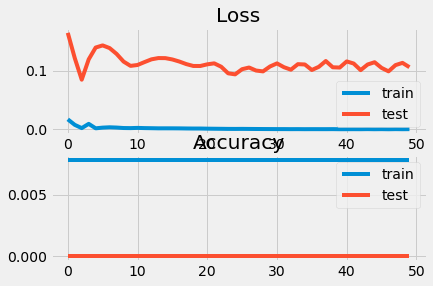

In [13]:
#Train the model
history = model.fit(feature_train, label_train, batch_size=512, epochs=50,validation_data = (feature_test, label_test))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [187]:
_, train_acc = model.evaluate(feature_train, label_train, verbose=0)
_, test_acc = model.evaluate(feature_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Train: 0.567, Test: 0.495
Saved model to disk


(128, 20, 104)
[[0.16637295]
 [0.1651223 ]
 [0.16543415]
 [0.16535899]
 [0.16362117]
 [0.16314693]
 [0.16332147]
 [0.16187456]
 [0.15959162]
 [0.15741594]
 [0.1556992 ]
 [0.15258782]
 [0.15175189]
 [0.14844657]
 [0.14617698]
 [0.14356652]
 [0.14017408]
 [0.1361143 ]
 [0.13194737]
 [0.12789539]
 [0.12412621]
 [0.11818655]
 [0.11466887]
 [0.11222089]
 [0.10969211]
 [0.10502986]
 [0.09911831]
 [0.08919812]
 [0.0828171 ]
 [0.06945187]
 [0.05969231]
 [0.05263087]
 [0.04573828]
 [0.0428007 ]
 [0.04151106]
 [0.0412699 ]
 [0.04170656]
 [0.04162365]
 [0.04312351]
 [0.04505634]
 [0.04700448]
 [0.04812469]
 [0.04959019]
 [0.05181701]
 [0.05390268]
 [0.05460645]
 [0.05721699]
 [0.05897866]
 [0.06076028]
 [0.06210809]
 [0.06380896]
 [0.06456947]
 [0.06616867]
 [0.06680316]
 [0.06718235]
 [0.06707844]
 [0.06750815]
 [0.06751775]
 [0.06708311]
 [0.06680668]
 [0.06804133]
 [0.0684242 ]
 [0.06864743]
 [0.06898624]
 [0.06889498]
 [0.06943905]
 [0.07136825]
 [0.07222546]
 [0.0725702 ]
 [0.07445067]
 [0.0

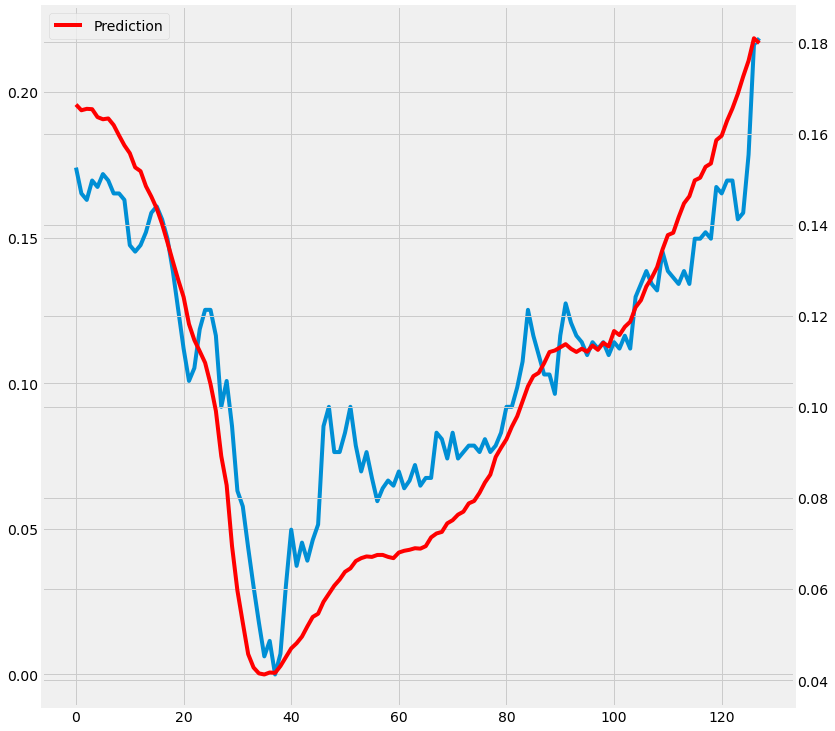

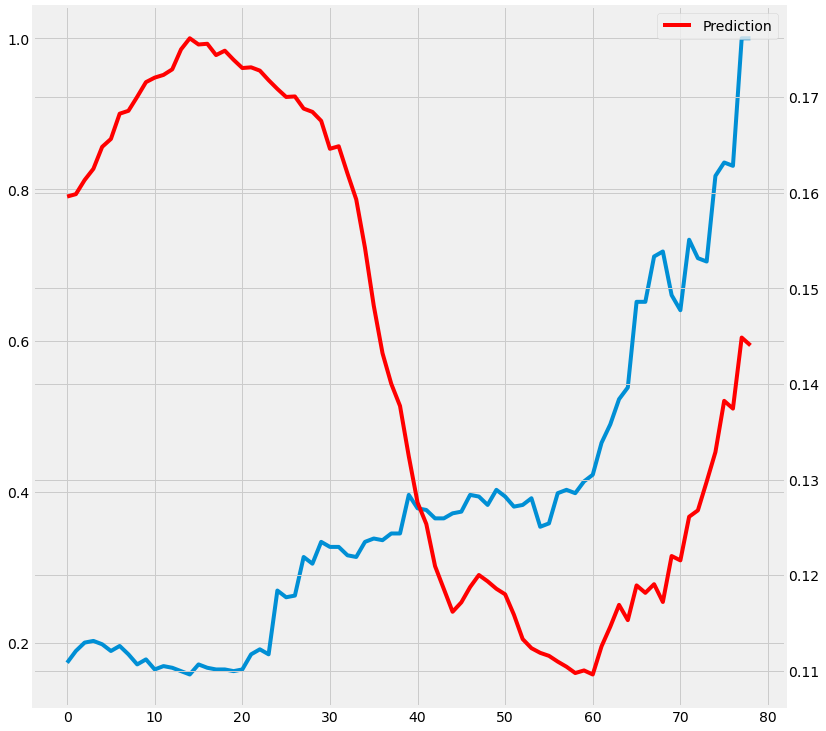

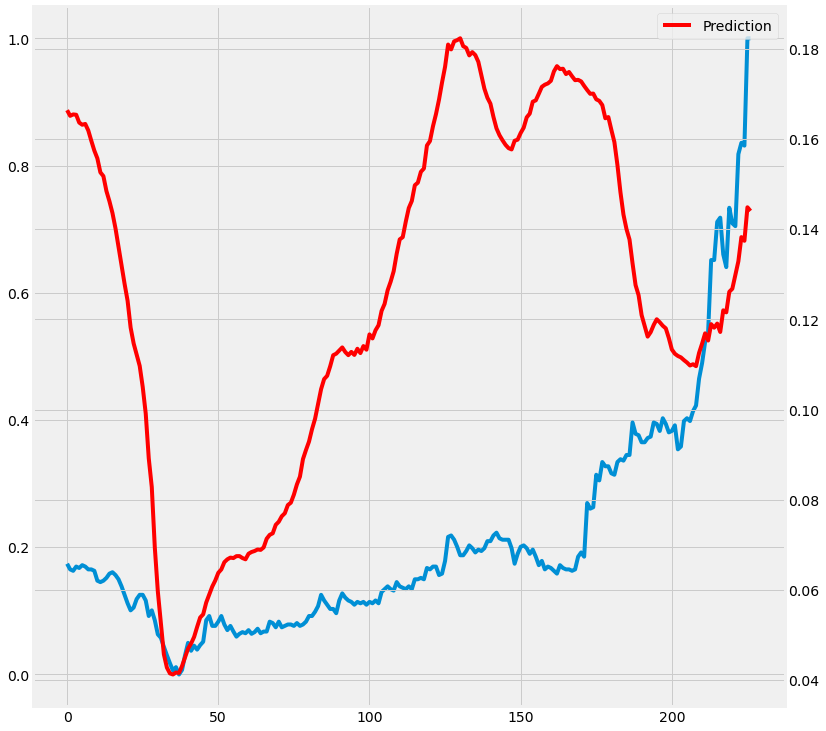

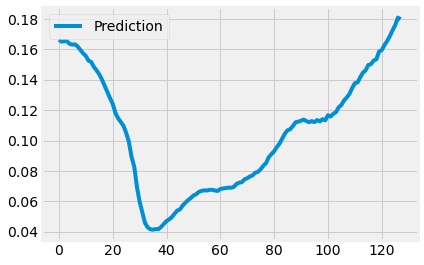

In [31]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_train)
print(feature_train.shape)
predicted_test = model.predict(feature_test)
# feature = np.append(feature_train,feature_test)
# feature = np.reshape(feature, (feature_train.shape[0]+feature_test.shape[0], feature_train.shape[1], feature_train.shape[2]))

pred_all_price = model.predict(feature)
# print(feature_test[-1::])
# print(label_test)
# print(label_test.shape)
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print(predicted_stock_price)
# print(predicted_stock_price)
print(np.mean(predicted_stock_price))
price=[]
for i in predicted_stock_price:
    if i[0]>=0.5:
        price.append(1)
    else:
        price.append(0)
price = np.array(price)
# print(price)
# print(price.shape)
plot_results(predicted_stock_price,label_train)
plot_results(predicted_test,label_test)
# label = np.append(label_train,label_test)
# label = np.reshape(label, (label_train.shape[0]+label_test.shape[0], label_train.shape[1], label_train.shape[2]))

plot_results(pred_all_price,label)

plot_result(predicted_stock_price)

In [ ]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 60)
plot_results_multiple(predictions, label_test, 100)  